<a href="https://colab.research.google.com/github/gourav3017/Algorithm/blob/master/Brain_Age_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Age Estimation using Machine Learning

---






In this notebook we use the python programming language to perform brain age estimation based on MRI images  

Lines beginning with a # are comments

You must execute each cell one by one by clicking inside the play symbol on the left


In [0]:
# Python uses packages containing functions
# Packages must be imported to be used. Here is a simple example.

# We first import the numpy package
import numpy as np
# We create a list X 
X = [4, 5, 3, 1, 2]
# We use the function "sort" to sort the list X and print the result
print(np.sort(X))
# If you click on the left, you will execute this cell and see the result

[1 2 3 4 5]


In [0]:
# We first import all the packages we will need for the project

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style('white')
plt.set_cmap('gist_gray')


# We also install a package to read NiFTI files
!pip install --quiet nibabel
import nibabel as nib

# We finally download the data from a GitHub repository
! git clone https://github.com/SimJeg/BrainAge.git

fatal: destination path 'BrainAge' already exists and is not an empty directory.


# Exploration of the dataset

In this section we will load the dataset and display some statistics and plots

In [0]:
# We open the demographics table using the pandas package (pd)
df = pd.read_csv('BrainAge/demographics.csv')
# We display the 10 first lines
df.head(10)

,id,dataset,sex,hospital,age,path_process_data
0,0,ixi,f,Guys,35.800137,IXI002/
1,1,ixi,m,HH,38.781656,IXI012/
2,2,ixi,m,HH,46.710472,IXI013/
3,3,ixi,f,HH,34.236824,IXI014/
4,4,ixi,m,HH,24.284736,IXI015/
5,5,ixi,m,Guys,55.167693,IXI016/
6,6,ixi,f,Guys,29.092402,IXI017/
7,7,ixi,m,Guys,58.658453,IXI019/
8,8,ixi,m,Guys,39.466119,IXI020/
9,9,ixi,f,Guys,21.566051,IXI021/


There are 1597 patients
There are 25 hospitals
There are 2 datasets
There are 55.48% of women
Age statistics : 
count    1597.000000
mean       35.599132
std        17.491271
min        18.000000
25%        22.000000
50%        27.000000
75%        48.052019
max        86.318960
Name: age, dtype: float64


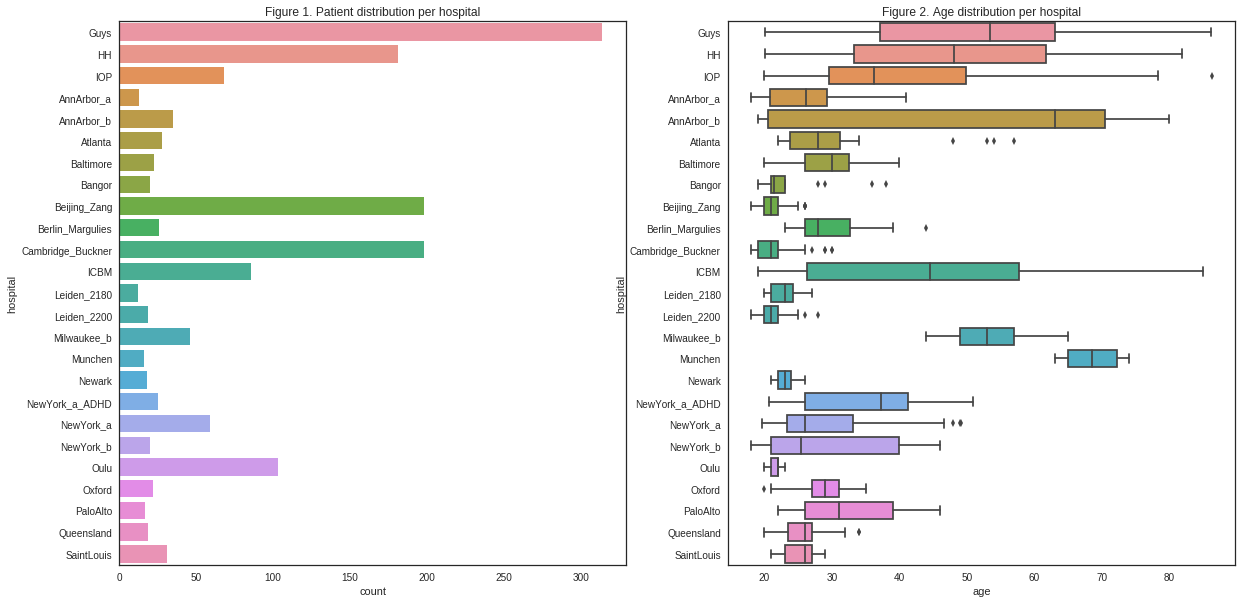

In [0]:
# We can use the packages matplotlib (plt) and seaborn (sns) to plot figures
# Figure 1 shows that patients are not equally distributed across hospitals
# Figure 2 shows that ages     are not equally distributed across hospitals


# We first print some statistics
print('There are {} patients'.format(len(df)))
print('There are {} hospitals'.format(len(df.hospital.unique())))
print('There are {} datasets'.format(len(df.dataset.unique())))
print('There are {:.2f}% of women'.format(100*np.mean(df.sex == 'f')))
print('Age statistics : ')
print(df.age.describe())

# We plot the patient count over hospitals
plt.figure(figsize=(20,10)) 
plt.subplot(121) 
sns.countplot(y='hospital', data=df)
plt.title('Figure 1. Patient distribution per hospital')

# We plot the age distribution over hospitals
plt.subplot(122)
sns.boxplot(x='age', y='hospital', data=df)
plt.title('Figure 2. Age distribution per hospital');

Shape of the MRI : (182, 218, 182)


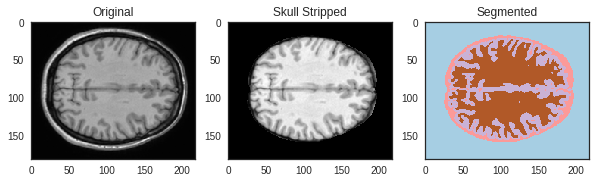

In [0]:
# In this cell, we plot one slice of the MRI of a subject

# We first load the 2 files associated to raw data and segmentation
image = nib.load('BrainAge/input.nii.gz').get_data()
segmentation = nib.load('BrainAge/segmentation.nii.gz').get_data()

# Is segmentation[i, j, k] == 0 it means the voxel ijk is not a brain tissue
# It allows to simply skullstrip the image : 
skullstripped_image = image * (segmentation > 0)

# The image and segmentation are 3D array of shape (182, 218, 182)
# Choose the dimension : 0 (sagittal), 1 (coronnal) or 2 (axial)
dimension = 2
# Choose the slice (between 0 and 182 or 218)
s = 100

plt.figure(figsize=(10, 5))
print('Shape of the MRI : {}'.format(image.shape))
plt.subplot(131)
plt.imshow(np.take(image, s, dimension))
plt.title('Original');

plt.subplot(132)
plt.imshow(np.take(skullstripped_image, s, dimension))
plt.title('Skull Stripped');

plt.subplot(133)
plt.imshow(np.take(segmentation, s, dimension), cmap='Paired')
plt.title('Segmented');

#Histograms

In this section we will create the histograms  of the MRIs and train a linear model on it to predict the age

## Load and visualize histograms

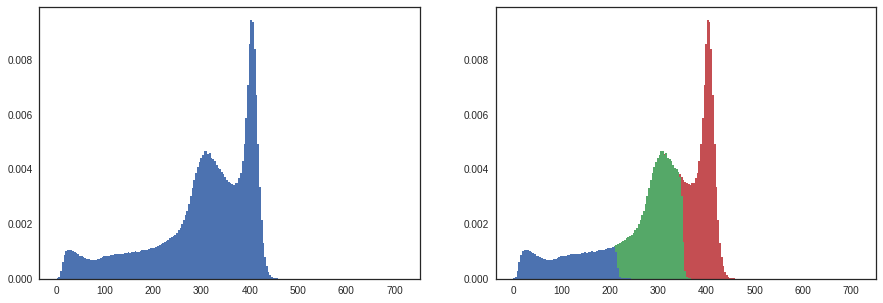

In [0]:
# We first show how an histogram looks like

plt.figure(figsize=(15, 5))
plt.subplot(121)
# We only use POSITIVE values (background removed) to compute the histogram
plt.hist(skullstripped_image[skullstripped_image > 0], bins=200, density=True); 

# Now use the segmentation and superpose the histograms of CSF (blue), 
# white matter (green) and grey matter (red) intensity values
plt.subplot(122)
plt.hist([skullstripped_image[segmentation == i] for i in [1, 2, 3]], 
         stacked=True, bins=200, density=True);

Shape of X : (1597, 200)


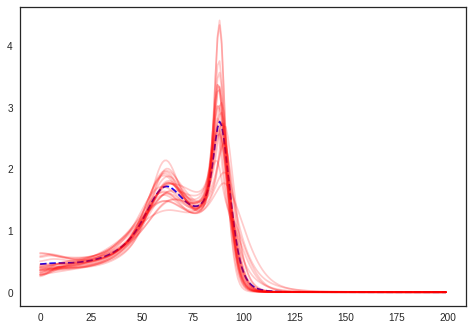

In [0]:
# Here display the average histograms per hospital in red

# Load the histograms X for all patients and the ages Y
X = np.load('BrainAge/histograms.npy')
Y = df.age.values
print('Shape of X : {}'.format(np.shape(X)))

# We plot the average histogram in blue
plt.plot(X.mean(0), 'b--')

# And the average histogram per hospital in red using a for loop
for h in df.hospital.unique():
  plt.plot(X[df.hospital == h].mean(0), 'r', alpha=0.2)

## Train a linear model 



In [0]:
10**np.linspace(-3.0, 2.0, 10)

array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02])

Random Split
Size of the test set : 320 patients


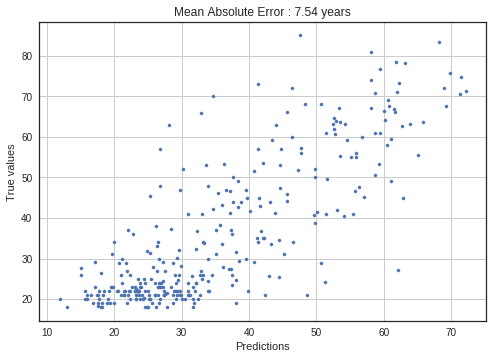

Hospital Split
Size of the test set : 314 patients


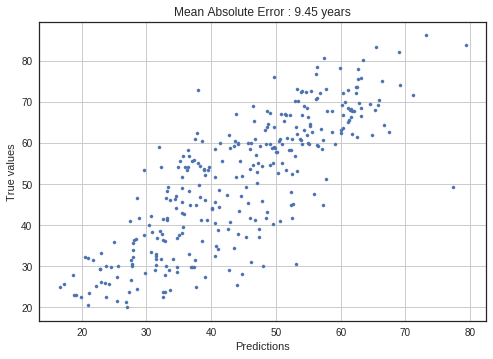

In [0]:
# Scikit Learn is the most popular package for machine learning in python
# We use it to train a linear model with L2 regularization (Ridge Regression)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
n_patients = len(df)

# We create a function to train and test a linear model

def train_linear_regression(train, test):
    # Create model
    model = RidgeCV()

    # Train on the training set : fit the models with pairs (X, Y)
    model.fit(X[train], Y[train])

    # Predict on the test set
    predictions = model.predict(X[test])
    true_values = Y[test]
    
    # Plot the results and compute the MAE
    plt.scatter(predictions, true_values, s=10)
    plt.grid()
    plt.xlabel('Predictions')
    plt.ylabel('True values')
    mae = np.mean(np.abs(predictions - true_values))
    plt.title('Mean Absolute Error : {:.2f} years'.format(mae))
    plt.show()


# We don't perform 5 fold cross validation here, but a single split

# 1. Random split
# We randomly split the data between train and test with 80/20 proportions
train, test = train_test_split(np.arange(n_patients), test_size=0.2,
                               random_state=0)
print('Random Split')
print('Size of the test set : {} patients'.format(len(test)))
# We use our function on this split
train_linear_regression(train, test)

# 2. Hospital split
# We split the hospitals using Guys hospital as the test set
train = np.where(df.hospital != 'Guys')[0]
test = np.where(df.hospital == 'Guys')[0]
print('Hospital Split')
print('Size of the test set : {} patients'.format(len(test)))
train_linear_regression(train, test)

# Convolutional Neural Networks

In this section we load a trained convolutional neural network and apply it on a single patient 

In [0]:
# We will use the keras package for deep learning models
from keras.models import load_model

# Training a model is very long, so here we simply load a trained model
model = load_model('BrainAge/cnn_model.h5')

# We show the model summary
# The input is an image of size (200, 200, 1) and the output the age of size 1
# You can see different layers : Convolutional, Pooling, Dense, and BatchNorm

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 198, 198, 32)      320       
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 196, 196, 32)      9248      
_________________________________________________________________
batch_normalization_41 (Batc (None, 196, 196, 32)      128       
_________________________________________________________________
average_pooling2d_41 (Averag (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 94, 94, 64)        36928     
__________

In [0]:
# Get predictions : we first need to prepare the input image
    
X = skullstripped_image

# Step 1 : Normalize Intensities
h, t = np.histogram(X[segmentation == 3], bins=100)
peak_wm = t[np.argmax(h)]
h, t = np.histogram(X[segmentation == 2], bins=100)
peak_gm = t[np.argmax(h)]

X /= peak_wm
C = peak_gm / peak_wm
a = (0.75 - C**2) / (C - C**2)
X[X < 1] = a * X[X < 1] + (1 - a) * X[X < 1]**2
X = np.clip(X, 0, 1.5) / 1.5

# Step 2 : resize the image to get (200, 200) shape

X = X[:, 10:-8, 80:90]
X = np.pad(X, ((9,9), (0,0), (0,0)), mode='constant')
X = np.rollaxis(X, 2, 0)[..., None]

# Step 3 : use the trained model to make the predictions

predictions = 10 * model.predict(X)[:, 0]


In [0]:
# The image provided here is the first of the dataset 
# This image was NOT in the training set of the  model

real_age = df.age[0]
print('Real age : {:.2f} years'.format(real_age))

# Our model made a prediction for each axial slice (10 in total)
# That's fact was a bit hidden in the blog post !
print('Number of predictions : {}'.format(len(predictions)))
print('Average prediction : {:.2f} years'.format(np.mean(predictions)))
print('Minimal prediction : {:.2f} years '.format(np.min(predictions)))
print('Maximal prediction : {:.2f} years '.format(np.max(predictions)))

Real age : 35.80 years
Number of predictions : 10
Average prediction : 31.16 years
Minimal prediction : 27.15 years 
Maximal prediction : 35.01 years 
